In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:51357" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:51377, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:51380, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:51374, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

# PCA
Reducing dimensionality to keep computation times practical

In [8]:
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)

# XGBoost Regressor 10 Estimators

We will be using XGBoosts tree booster so it will be similar to RandomForest as opposed to a linear model. We'll work with 10, 50 and 250 estimators as we did with RandomForest to find the best result.

In [9]:
#create and fit model
xgb10 = XGBRegressor(n_estimators=10)
with joblib.parallel_backend('dask'):
    xgb10.fit(train_X_pca50, train_y)

In [10]:
#Create dictionary for logging
xgb_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in xgb10.get_params():
    xgb_scores[param]=[]

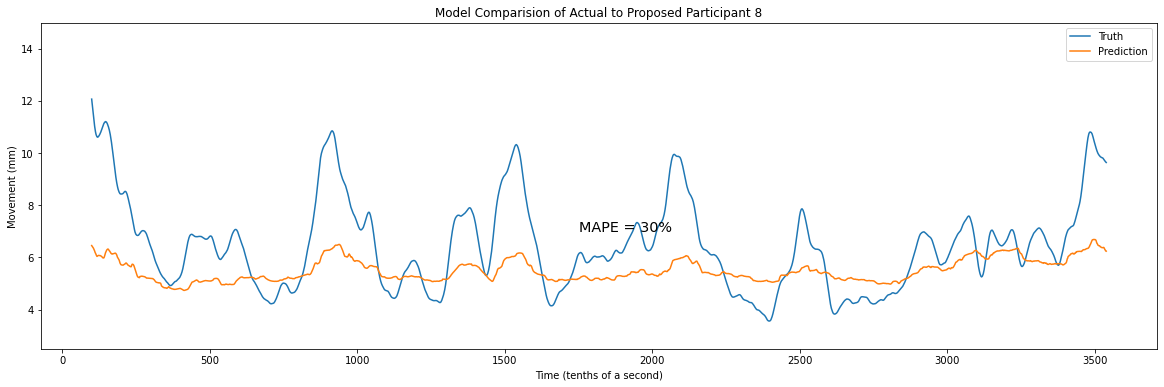

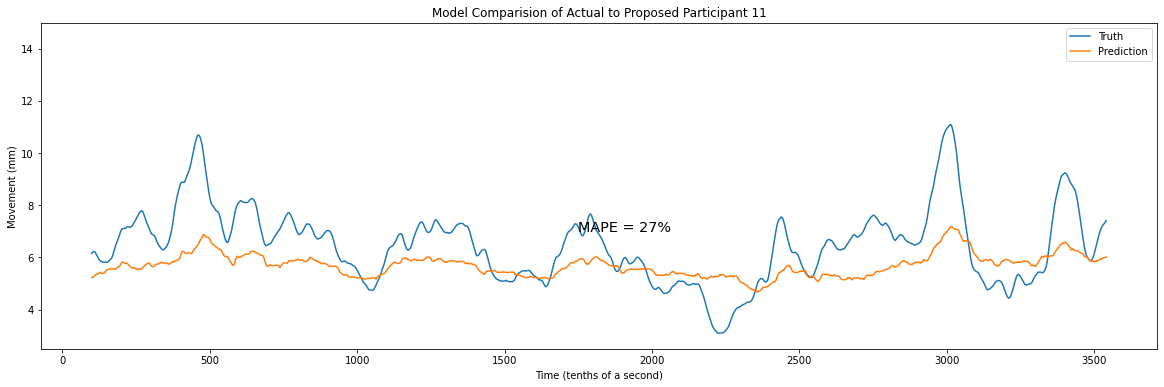

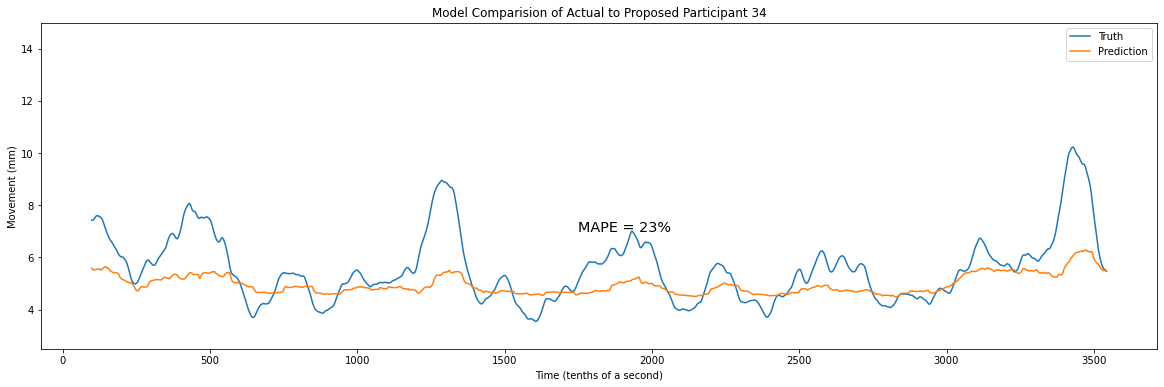

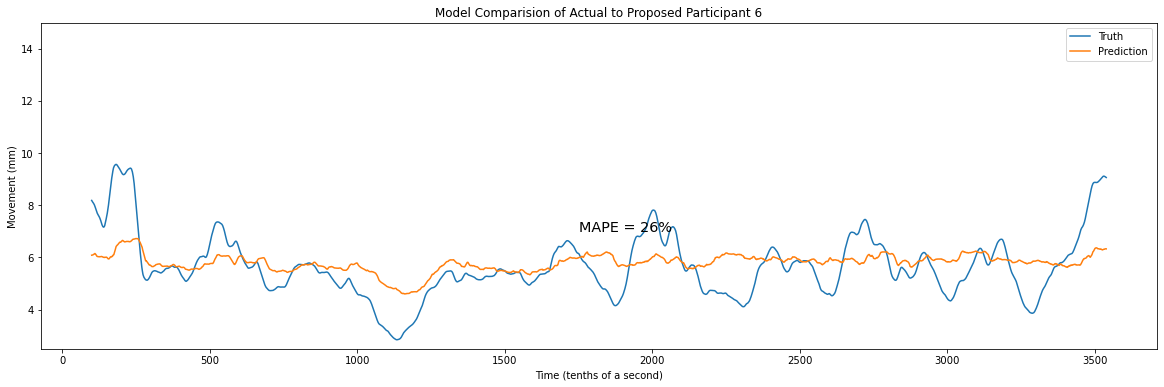

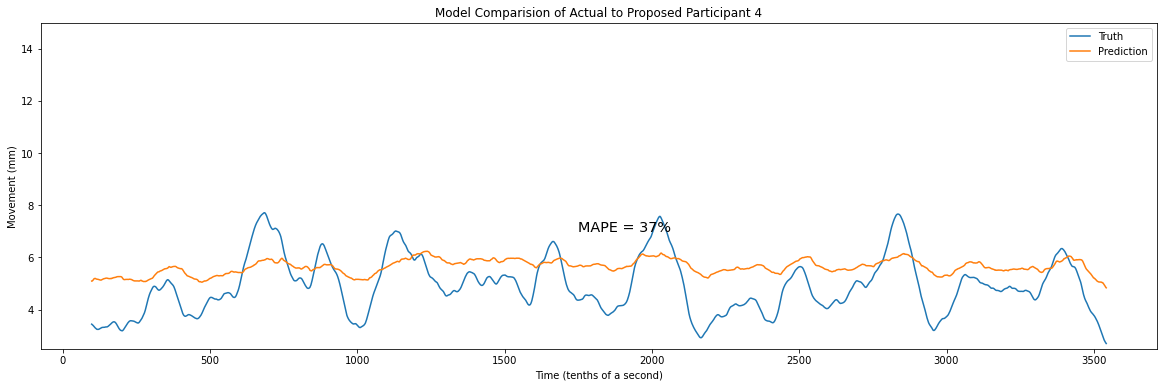

In [11]:
#visualize preictions and truths
results, xgb_scores = score_model(xgb10, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='XGB10', log = xgb_scores)
plot_predictions(results, participants)

XGB did pretty well out of the box, less jumpy than RandomForest, but still able to follow the trends.

In [12]:
xgb_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

# XGBoost Regressor 50 Estimators

In [13]:
#create and fit model
xgb50 = XGBRegressor(n_estimators=50)
with joblib.parallel_backend('dask'):
    xgb50.fit(train_X_pca50, train_y)

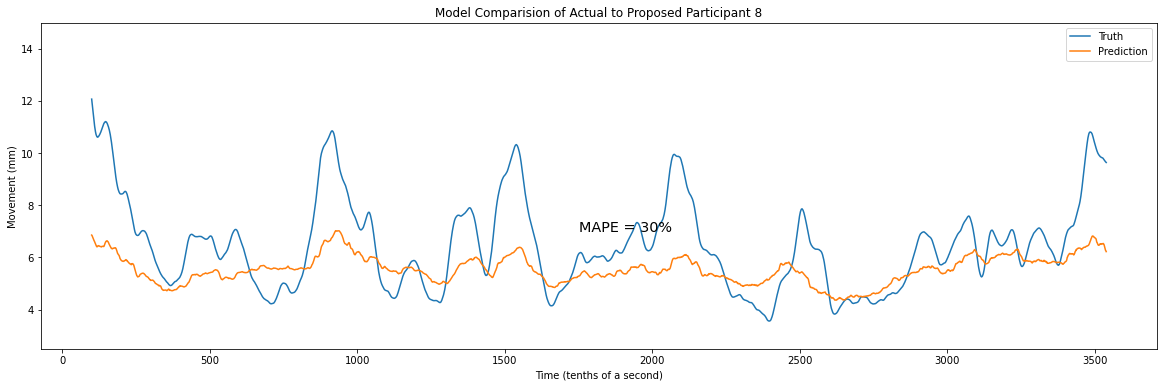

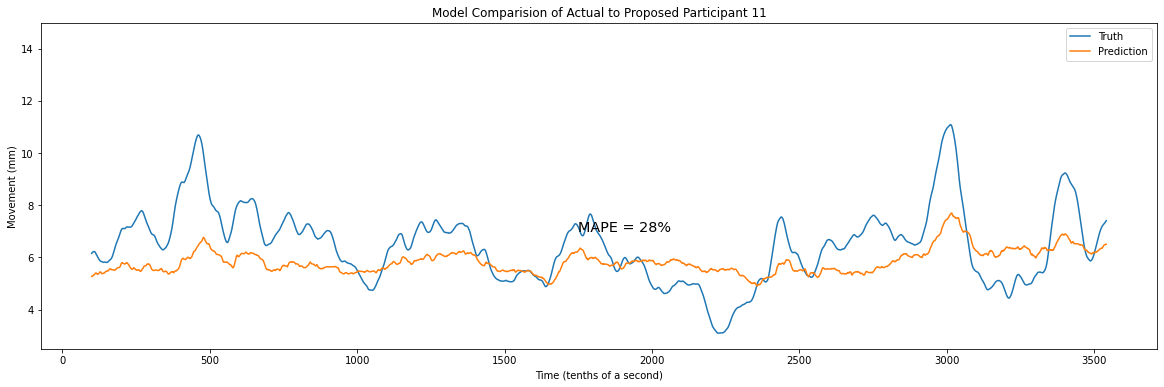

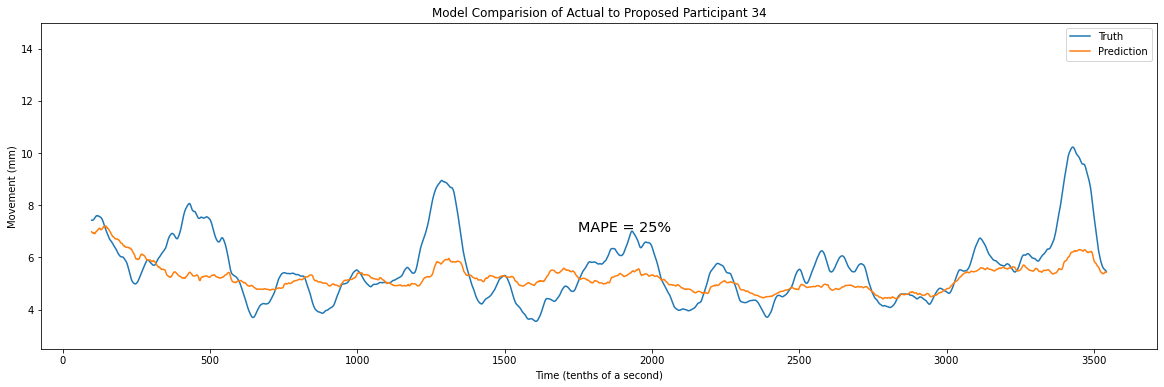

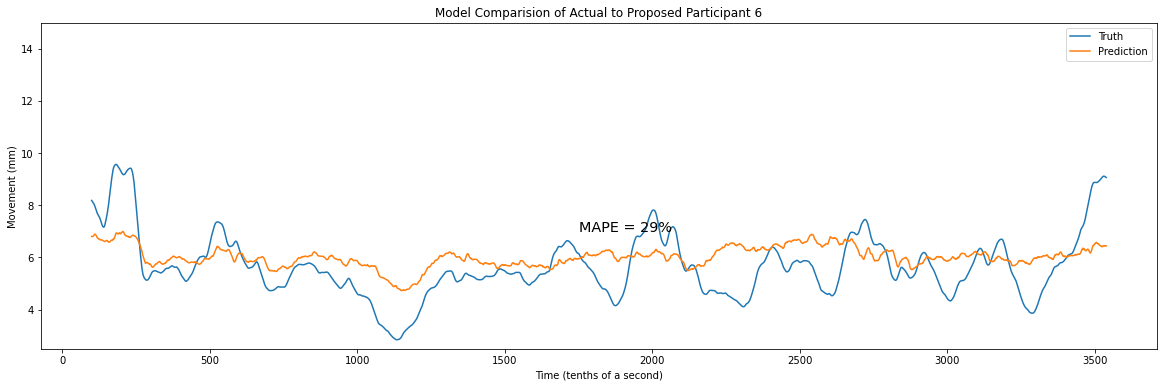

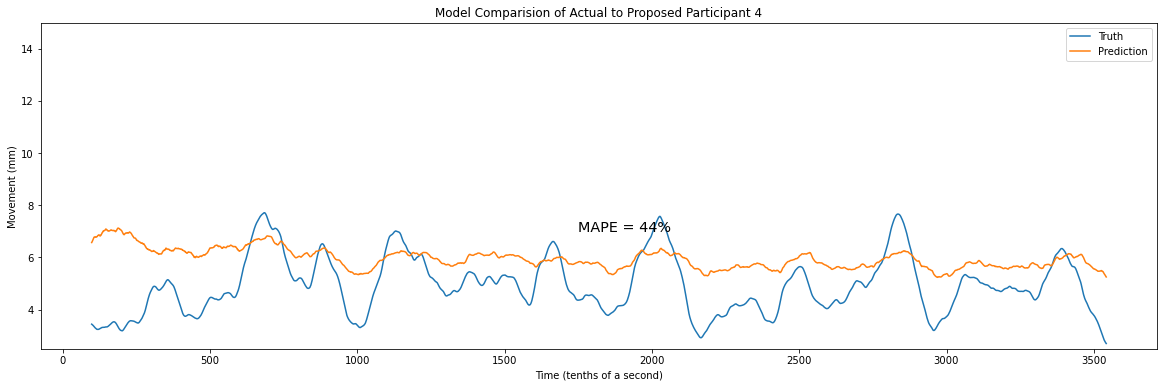

In [14]:
#visualize preictions and truths
results, xgb_scores = score_model(xgb50, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='XGB50', log = xgb_scores)
plot_predictions(results, participants)

We actually did slightly worse. Let's continue up to 250 estimators and see fi the trend holds.

# XGBoost Regressor 250 Estimators

In [15]:
#create and fit model
xgb250 = XGBRegressor(n_estimators=250)
with joblib.parallel_backend('dask'):
    xgb250.fit(train_X_pca50, train_y)

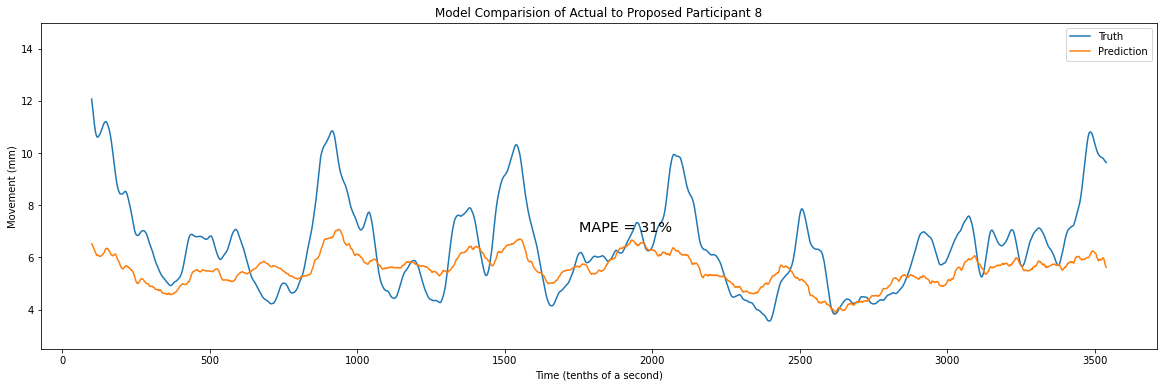

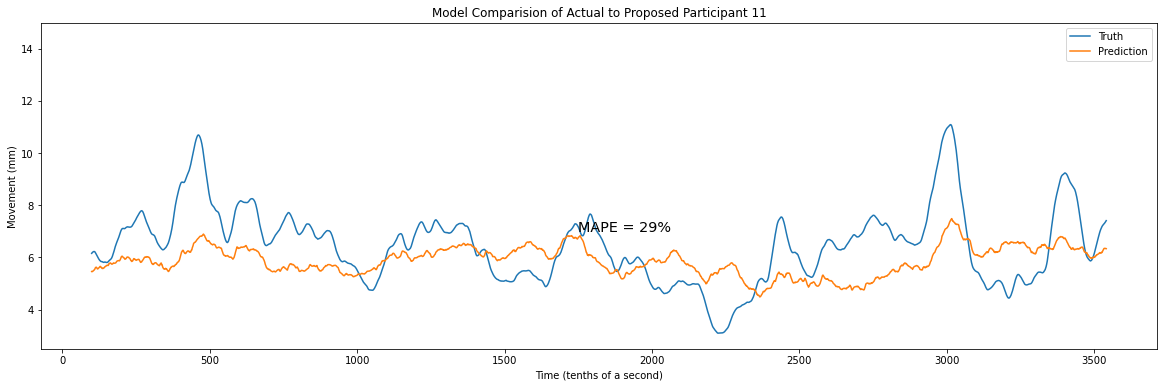

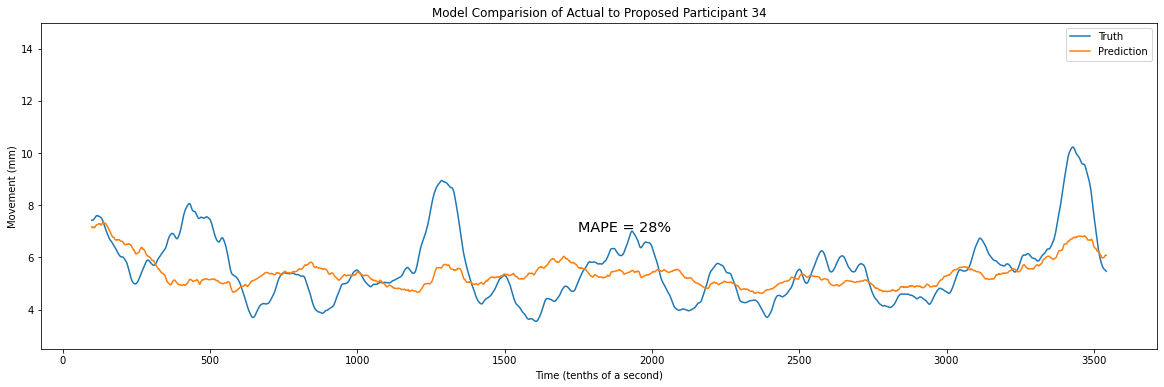

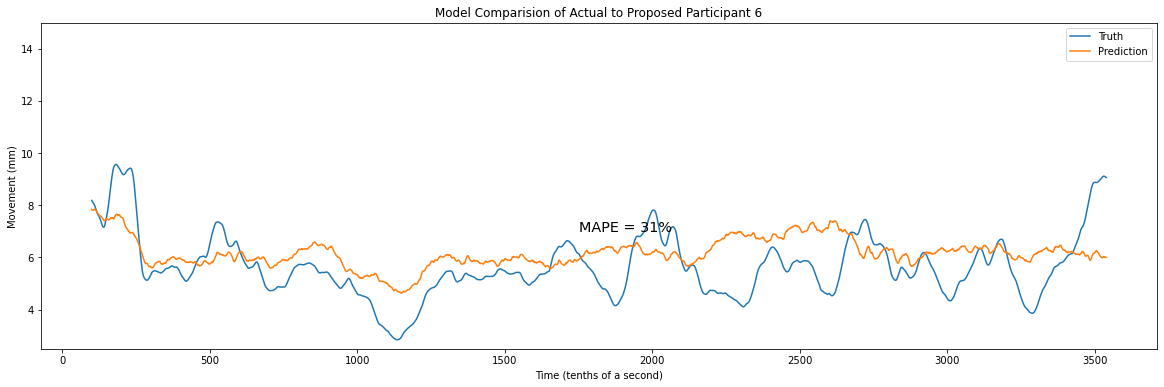

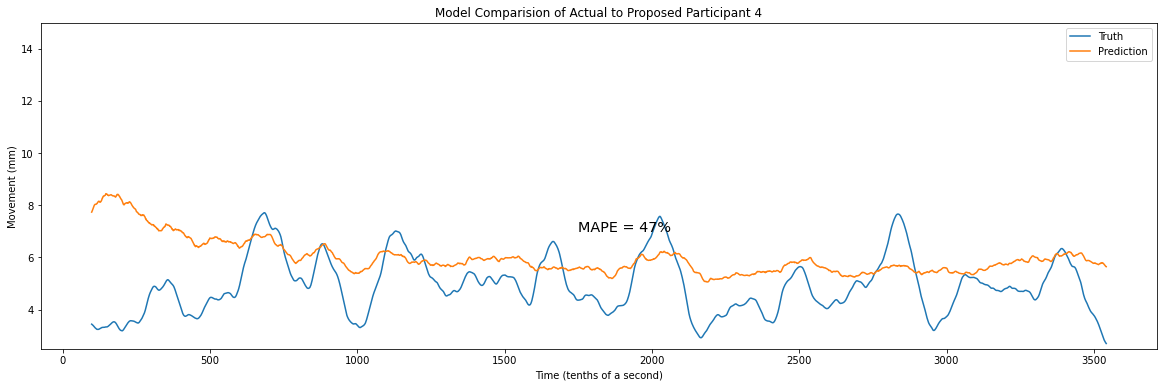

In [16]:
#visualize preictions and truths
results, xgb_scores = score_model(xgb250, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='XGB250', log = xgb_scores)
plot_predictions(results, participants)

Again slightly worse and we can see here that we are also less smooth the more estimators we add on. Tuning some other features may be a better route to take than adding on estiamtors. The linear models have done well so far, let's try usng XGB's gblinear booster.

# XGBoost Regressor 250 Estimators, GBLinear

In [17]:
#create and fit model
xgblin = XGBRegressor(n_estimators=250, booster='gblinear')
with joblib.parallel_backend('dask'):
    xgblin.fit(train_X_pca50, train_y)

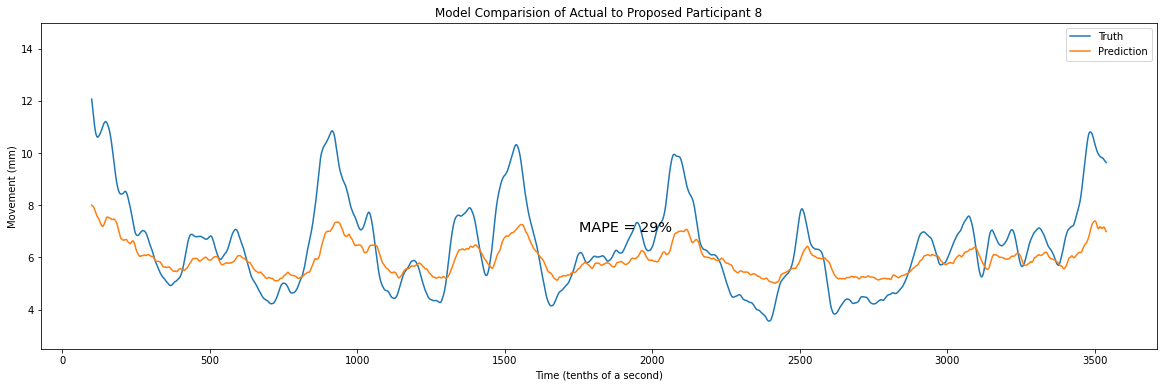

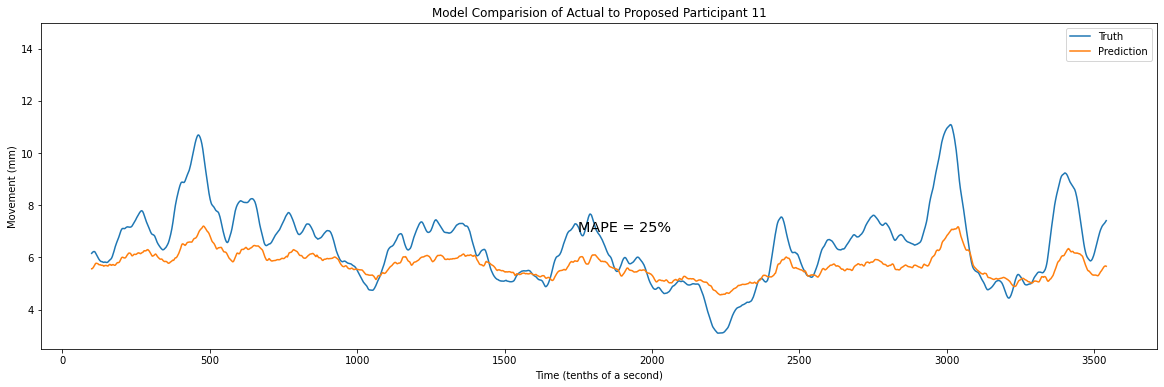

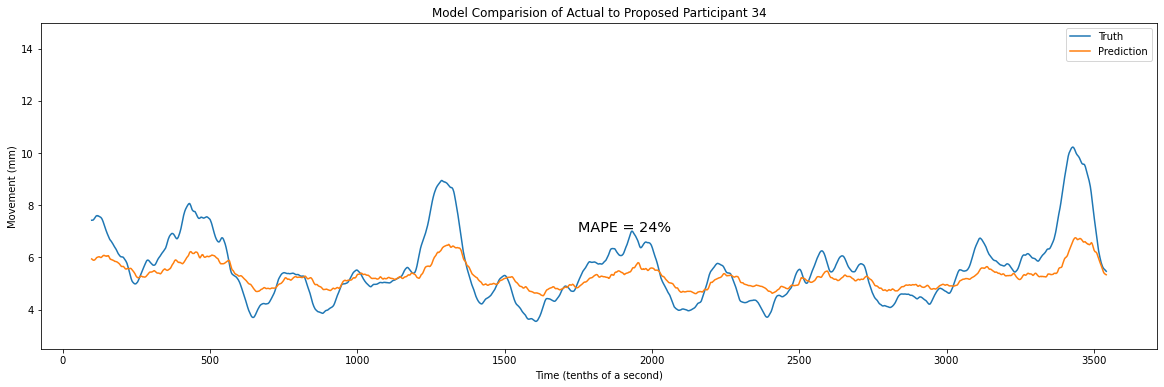

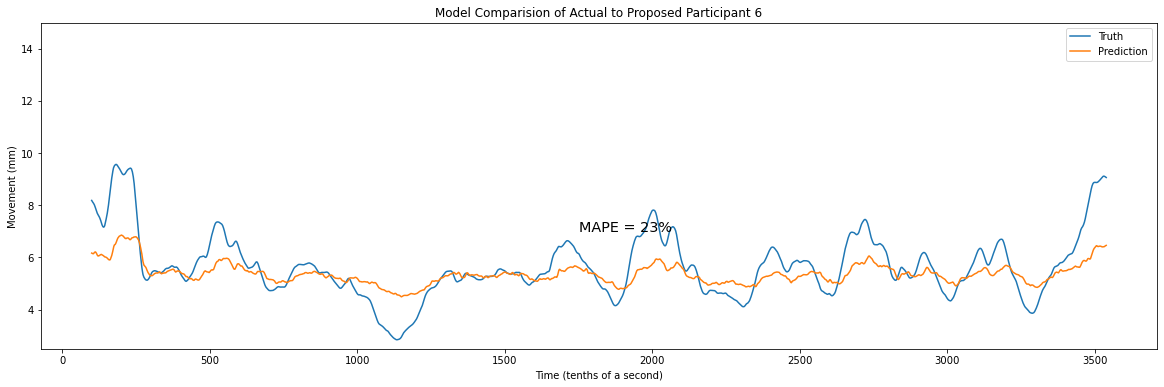

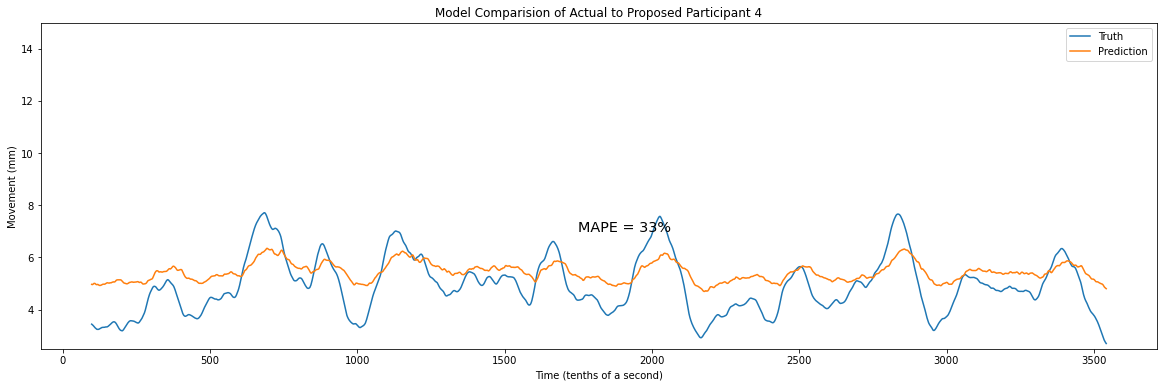

In [18]:
#visualize preictions and truths
results, xgb_scores = score_model(xgblin, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='XGB250_LIN', log = xgb_scores)
plot_predictions(results, participants)

Much better. We should stick with XGB's linear booster for any future parameter tuning. It also decreases the computation time so it's a win-win.

In [19]:
#convert metrics dictionary to dataframe
xgb_df = pd.DataFrame(xgb_scores)

In [20]:
#View model metrics and parameters by participant
xgb_df.groupby(['par','model']).mean()

MAPE       MAE  base_score  colsample_bylevel  \
par model                                                           
4   XGB10       0.378077  1.460071         0.5                1.0   
    XGB250      0.477905  1.809256         0.5                1.0   
    XGB250_LIN  0.332335  1.312325         0.5                NaN   
    XGB50       0.442413  1.674384         0.5                1.0   
6   XGB10       0.267067  1.383389         0.5                1.0   
    XGB250      0.317377  1.595963         0.5                1.0   
    XGB250_LIN  0.230570  1.283420         0.5                NaN   
    XGB50       0.295148  1.501889         0.5                1.0   
8   XGB10       0.303315  2.028813         0.5                1.0   
    XGB250      0.314286  2.073345         0.5                1.0   
    XGB250_LIN  0.292802  1.852961         0.5                NaN   
    XGB50       0.301351  1.994280         0.5                1.0   
11  XGB10       0.270660  1.743066         0.5                1.0   
    XGB250      0.293288  1.832499         0.5                1.0   
    XGB250_LIN  0.252206  1.651298         0.5                NaN   
    XGB50       0.280823  1.757461         0.5                1.0   
34  XGB10       0.236541  1.361361         0.5                1.0   
    XGB250      0.281725  1.482833         0.5                1.0   
    XGB250_LIN  0.241635  1.319128         0.5                NaN   
    XGB50       0.252976  1.386477         0.5                1.0   

                colsample_bynode  colsample_bytree  gamma  gpu_id  \
par model                                                           
4   XGB10                    1.0               1.0    0.0      -1   
    XGB250                   1.0               1.0    0.0      -1   
    XGB250_LIN               NaN               NaN    NaN      -1   
    XGB50                    1.0               1.0    0.0      -1   
6   XGB10                    1.0               1.0    0.0      -1   
    XGB250                   1.0               1.0    0.0      -1   
    XGB250_LIN               NaN               NaN    NaN      -1   
    XGB50                    1.0               1.0    0.0      -1   
8   XGB10                    1.0               1.0    0.0      -1   
    XGB250                   1.0               1.0    0.0      -1   
    XGB250_LIN               NaN               NaN    NaN      -1   
    XGB50                    1.0               1.0    0.0      -1   
11  XGB10                    1.0               1.0    0.0      -1   
    XGB250                   1.0               1.0    0.0      -1   
    XGB250_LIN               NaN               NaN    NaN      -1   
    XGB50                    1.0               1.0    0.0      -1   
34  XGB10                    1.0               1.0    0.0      -1   
    XGB250                   1.0               1.0    0.0      -1   
    XGB250_LIN               NaN               NaN    NaN      -1   
    XGB50                    1.0               1.0    0.0      -1   

                learning_rate  max_delta_step  ...  missing  n_estimators  \
par model                                      ...                          
4   XGB10                 0.3             0.0  ...      NaN            10   
    XGB250                0.3             0.0  ...      NaN           250   
    XGB250_LIN            0.5             NaN  ...      NaN           250   
    XGB50                 0.3             0.0  ...      NaN            50   
6   XGB10                 0.3             0.0  ...      NaN            10   
    XGB250                0.3             0.0  ...      NaN           250   
    XGB250_LIN            0.5             NaN  ...      NaN           250   
    XGB50                 0.3             0.0  ...      NaN            50   
8   XGB10                 0.3             0.0  ...      NaN            10   
    XGB250                0.3             0.0  ...      NaN           250   
    XGB250_LIN            0.5             NaN  ...      Na

In [21]:
#view model metrics
xgb_df.groupby(['model']).mean()

,par,MAPE,MAE,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,gpu_id,learning_rate,...,missing,n_estimators,n_jobs,num_parallel_tree,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,validate_parameters
model,,,,,,,,,,,,,,,,,,,,,
XGB10,12.6,0.291132,1.595340,0.5,1.0,1.0,1.0,0.0,-1.0,0.3,...,NaN,10.0,6.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
XGB250,12.6,0.336916,1.758779,0.5,1.0,1.0,1.0,0.0,-1.0,0.3,...,NaN,250.0,6.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
XGB250_LIN,12.6,0.269910,1.483826,0.5,NaN,NaN,NaN,NaN,-1.0,0.5,...,NaN,250.0,6.0,NaN,0.0,0.0,0.0,1.0,NaN,1.0
XGB50,12.6,0.314542,1.662898,0.5,1.0,1.0,1.0,0.0,-1.0,0.3,...,NaN,50.0,6.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [22]:
#output for comparison
xgb_df.to_pickle(r'DFs/scores/xgb.pkl')